## Model Fitting: Likelihood and Chi-Squared

Model fitting is the process of finding the best parameters for a model that describe observed data. Two commonly used statistical methods for this purpose are the **likelihood function** and the **chi-squared ($\chi^2$) statistic**. These methods quantify the agreement between the model and the data, guiding the optimization of model parameters.

---

### Key Concepts

- **Chi-Squared Statistic ($\chi^2$)**:
  - Measures the goodness-of-fit by summing the squared residuals normalized by their uncertainties:
    $$\chi^2 = \sum_i \frac{\left(y_{\text{obs},i} - y_{\text{model},i}\right)^2}{\sigma_i^2}$$
  - A smaller $\chi^2$ indicates a better fit.
  - **Reduced Chi-Squared ($\chi^2_{\text{red}}$)** accounts for degrees of freedom:
    $$\chi^2_{\text{red}} = \frac{\chi^2}{N - p}$$
    where $N$ is the number of data points and $p$ is the number of model parameters.

- **Likelihood Function ($\mathcal{L}$)**:
  - Represents the probability of observing the data given a model:
    $$\mathcal{L}(\theta) = \prod_i \frac{1}{\sqrt{2\pi}\sigma_i} \exp \left( -\frac{\left(y_{\text{obs},i} - y_{\text{model},i}(\theta)\right)^2}{2\sigma_i^2} \right)$$
  - In practice, the **log-likelihood** is maximized to simplify computations:
    $$\ln \mathcal{L}(\theta) = -\frac{1}{2} \sum_i \left[ \ln(2\pi\sigma_i^2) + \frac{\left(y_{\text{obs},i} - y_{\text{model},i}(\theta)\right)^2}{\sigma_i^2} \right]$$

---

### SED Fitting with SEDFitter

The equations above directly relate to fitting the spectral energy distributions (SEDs) of young stellar objects (YSOs):

1. **Observed Data ($y_{\text{obs},i}$)**:
   - Represents the photometric fluxes of YSOs measured in various filters (e.g., Gaia, 2MASS, WISE).
   - These fluxes are the input data for the fitting process.

2. **Model Predictions ($y_{\text{model},i}$)**:
   - Represent the theoretical fluxes predicted by the SED models for specific physical parameters, such as stellar temperature, disk mass, and extinction.
   - The models are pre-computed and convolved with the same filter response functions as the observations.

3. **Uncertainties ($\sigma_i$)**:
   - Correspond to the photometric errors associated with the observed fluxes.
   - These uncertainties weigh the residuals in both $\chi^2$ and likelihood calculations, emphasizing data points with smaller errors.

In this notebook, we will use **SEDFitter** to implement this framework. By minimizing the $\chi^2$ statistic or maximizing the likelihood function, we aim to identify the best-fitting models for the observed SEDs of YSOs. This allows us to infer their physical properties, such as the size and temperature of their central stars, the structure and mass of their circumstellar disks, and the level of extinction in their surrounding environment.

</div>

--- 

## Installing SEDFitter
Instructions to download SEDFitter are available here: [SEDFitter Installation](https://sedfitter.readthedocs.io/en/stable/installation.html)

## Downloading the SED Models
SEDFitter only includes the code to perform the model fitting, not the models themselves. We will be using the SED models from this paper: [SED Models Paper](https://arxiv.org/abs/1703.05765)

- Navigate to the following data repository: [Zenodo Repository](https://zenodo.org/records/166732)
- Scroll and click on the file `sp--s-i.tar.gz` (this will download to your computer).
- Go to the location on your computer where the file downloaded.
- Double click on the file so that it unzips/untars.
- You should now have a folder titled 'sp--s-i' that contains `models.conf`, `parameters.fits`, `stellar.fits`, `flux.fits`, and a sub-directory titled 'convolved'.

## Questions
- If you run into any issues you can contact me at: cameren.swiggum@univie.ac.at
- Just make sure you do this well in advance of any due date.

</div>

In [36]:
# After installing SEDFitter, you will also need to PIP install the following packages:
# run: pip install pandas 

import numpy as np
import matplotlib.pyplot as plt
from astropy.coordinates import SkyCoord
from astropy.io import fits
import astropy.units as u
import pandas as pd
import warnings
warnings.filterwarnings('ignore')

## Read in the data file: 'orion_stars.csv'
Data comes from Großschedl et al. 2019: https://www.aanda.org/articles/aa/abs/2019/02/aa32577-18/aa32577-18.html

In [37]:
path_to_data = './orionA_stars.csv' # Change this to the path of the data file you have downloaded
path_to_formatted_data = './orionA_stars_fitter_formatted' # Change this to the path of the data file you have downloaded
df_fitter_formatted = pd.read_csv(path_to_formatted_data, delim_whitespace=True, header=None)
df = pd.read_csv(path_to_data)
print(len(df))

3117


In [38]:
other_cols = ['name', 'ra', 'dec']
filters_mags = [
    'Jmag', 'Hmag', 'Ksmag',
    'W1mag', 'W2mag', 'W3mag', 'W4mag'
]
filter_names = [
    'J', 'H', 'Ks',
    'W1', 'W2', 'W3', 'W4'
]
# Effective wavelengths (in microns) for each filter
wavelengths = np.array([
    1.235,  # 2MASS J band
    1.662,  # 2MASS H band
    2.159,  # 2MASS Ks band
    3.4,    # WISE W1
    4.6,    # WISE W2
    12.0,   # WISE W3
    22.0    # WISE W4
])

# Plot an example SED

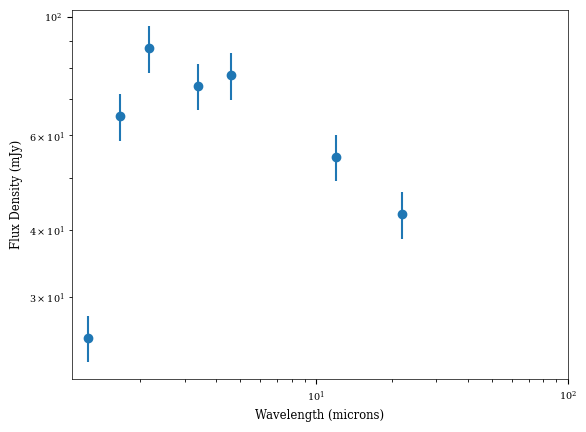

In [39]:
# Plot an exampe SED
star = df.iloc[10]
fluxes = star[[f"{filter_name}_flux" for filter_name in filter_names]].values
flux_errors = star[[f"{filter_name}_flux_err" for filter_name in filter_names]].values

plt.figure()
plt.errorbar(wavelengths, fluxes, yerr=flux_errors, fmt='o')
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Wavelength (microns)')
plt.ylabel('Flux Density (mJy)')
plt.xlim(-100, 100)
plt.show()

In [40]:
#stars = df_fitter_formatted.iloc[0:200] # run on only the first 20 stars, good for testing
stars = df_fitter_formatted # run on all stars
stars.to_csv('stars_to_fit', sep=' ', index=False, header=False) # Save to a new file in the desired format for SEDFitter

In [41]:
from astropy import units as u
from sedfitter import fit
from sedfitter.extinction import Extinction

# Define path to models
model_dir = '/Users/cam/Downloads/sp--s-i/' # NOTE: Change this to the path of the models you have downloaded
extinction_file = './kmh94.par'

# Read in extinction law)
extinction = Extinction.from_file(extinction_file, columns=[0, 3],
                                  wav_unit=u.micron, chi_unit=u.cm**2 / u.g)

# Run the Fitter

In [42]:
# Define filters and apertures
filters = ['2J', '2H', '2K', 'WISE1', 'WISE2', 'WISE3', 'WISE4'] 
apertures = [4., 4., 4., 8., 8., 16., 22.] * u.arcsec
#apertures = [3., 3., 3., 3., 3., 3., 3.] * u.arcsec

# Run the fitting
fit('stars_to_fit', filters, apertures, model_dir,
    'output.fitinfo',
    extinction_law=extinction,
    distance_range=[0.40, .42] * u.kpc,
    av_range=[0., 80.])

 ------------------------------------------------------------
  => Model parameters
 ------------------------------------------------------------

   Models              :  sp--s-i
   Log[d] stepping     :  0.02
   Number of distances :  3

 ------------------------------------------------------------
  => Reading in convolved fluxes
 ------------------------------------------------------------

Data shape=(90000, 3, 7).  use_memmap=True
   Reading /Users/cam/Downloads/sp--s-i//convolved/2J.fits
   Reading /Users/cam/Downloads/sp--s-i//convolved/2H.fits
   Reading /Users/cam/Downloads/sp--s-i//convolved/2K.fits
   Reading /Users/cam/Downloads/sp--s-i//convolved/WISE1.fits
   Reading /Users/cam/Downloads/sp--s-i//convolved/WISE2.fits
   Reading /Users/cam/Downloads/sp--s-i//convolved/WISE3.fits
   Reading /Users/cam/Downloads/sp--s-i//convolved/WISE4.fits
 ------------------------------------------------------------
  => Fitting parameters
 ----------------------------------------------

In [43]:
# from sedfitter import plot
# plot(
#     input_fits = 'output.fitinfo', 
#     output_dir = 'plots_seds'
#     #select_format = ('A', 6)
#     )

In [44]:
from sedfitter import write_parameters, write_parameter_ranges
# Write out all models with a delta chi^2-chi_best^2 per datapoint < 3
# Write out the min/max ranges corresponding to the above file
write_parameter_ranges('output.fitinfo', 'parameter_ranges.txt',
                       select_format=('F', 3.))

In [45]:
from astropy.io import ascii

# File path
file_path = "parameter_ranges.txt"

# Read the file with Astropy, skipping problematic parts
data = ascii.read(
    file_path,
    format="basic",  # Basic ASCII format
    guess=False,     # Don't guess the format
    header_start=1,  # Line index for the main header (second header)
    data_start=3     # Line index for the data (after dashed lines)
)

# Convert to Pandas DataFrame for further analysis if needed
df_params = data.to_pandas()

In [46]:
param_names = ['chi2', 'av', 'scale', 'star.radius', 'star.temperature', 'disk.mass', 'disk.rmax', 'disk.beta', 'disk.p', 'disk.h100', 'scattering', 'inclination']
for i, param_name in enumerate(param_names):
    if i == 0:
        df_params.rename(columns={
            'min': f'{param_name}_min',
            'best': f'{param_name}_best',
            'max': f'{param_name}_max'
        }, inplace=True)
    else:
        df_params.rename(columns={
            f'min_{i}': f'{param_name}_min',
            f'best_{i}': f'{param_name}_best',
            f'max_{i}': f'{param_name}_max'
        }, inplace=True)

In [47]:
df_params

,source_name,n_data,n_fits,chi2_min,chi2_best,chi2_max,av_min,av_best,av_max,scale_min,...,disk.p_max,disk.h100_min,disk.h100_best,disk.h100_max,scattering_min,scattering_best,scattering_max,inclination_min,inclination_best,inclination_max
0,star_0,7,164,5.5550,5.5550,26.46,0.00000,1.7790,5.456,-0.3979,...,-0.064560,1.010,3.051,18.500,1.0,1.0,1.0,2.26800,82.460,85.81
1,star_1,7,133,10.9400,10.9400,31.80,1.41800,5.5440,8.015,-0.3979,...,-0.009517,1.204,3.250,18.830,1.0,1.0,1.0,2.37000,44.810,87.92
2,star_2,7,252,1.8250,1.8250,22.82,0.00000,2.6020,4.551,-0.3979,...,-0.000303,1.143,2.916,18.970,1.0,1.0,1.0,0.06957,59.650,87.97
3,star_3,7,145,0.4898,0.4898,21.36,0.00000,0.3825,3.851,-0.3979,...,-0.094990,1.138,2.967,19.890,1.0,1.0,1.0,0.04084,78.350,87.06
4,star_4,7,310,1.0620,1.0620,22.06,0.00000,3.8030,5.623,-0.3979,...,-0.001641,1.223,1.883,19.210,1.0,1.0,1.0,0.05214,9.568,88.20
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3112,star_3112,7,1,4564.0000,4564.0000,4564.00,35.76000,35.7600,35.760,-0.3873,...,-0.994500,7.955,7.955,7.955,1.0,1.0,1.0,88.33000,88.330,88.33
3113,star_3113,7,60,3.9450,3.9450,24.88,0.08378,2.3630,4.016,-0.3979,...,-0.266900,1.031,1.112,11.400,1.0,1.0,1.0,0.11410,85.270,85.27
3114,star_3114,7,276,2.3850,2.3850,23.25,0.00000,1.4310,12.050,-0.3979,...,-0.001294,1.182,3.091,19.480,1.0,1.0,1.0,0.09992,56.470,85.39
3115,star_3115,7,18,25.0800,25.0800,45.31,0.00000,0.0000,2.794,-0.3979,...,-0.056420,1.090,1.386,3.933,1.0,1.0,1.0,16.22000,63.760,88.48


In [48]:
df_final = pd.merge(stars, df_params, left_index=True, right_index=True, suffixes=('', '_y'))
df_final = df_final.loc[:, [col for col in df_final.columns if isinstance(col, str) and not col.endswith('_y')]]
df_final.to_csv('sed_fitter_results.csv', index=False)